In [ ]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
import pandas as pd
from itertools import product

In [2]:
def remove_pattern(col_name):
    return re.sub(r'_[0-9]{3}$', '', col_name)

Zones = pd.read_excel('Zones.xlsx')
Dataset = pd.read_csv('KAG 2016-17/Agriculture/Agriculture_KAG_2016_17.csv')
Dataset.columns = map(remove_pattern, Dataset.columns)

param = pd.read_csv('Params/3_Param_Maize_Multicollinearity.csv')

Working_Directory = pd.read_csv('Working_Directory.csv')
Working_Directory = Working_Directory[['District','Maize_Production','TotalNPK',
'LivestockCensus_2012_Cattle', 'AreaUnderCereals_Maize','Maize_Ratio']].copy()

for x in param.columns:
    if(x != 'AreaUnderCereals_Maize'):
        Working_Directory[x] = Working_Directory[x]*Working_Directory['Maize_Ratio']

Working_Directory[24:]

,District,Maize_Production,TotalNPK,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,Maize_Ratio
24,BALLARI,104045,8404.154608,23446.847903,49869.5,0.136288
25,BIDAR,2791,249.381182,2371.831678,1382.0,0.010114
26,KALABURAGI,14621,710.101614,6221.617910,2634.0,0.013150
27,YADGIRI,2673,368.617469,1253.317144,961.0,0.004033
28,RAICHUR,723,61.547519,188.537479,2600.0,0.000525
29,KOPPAL,190252,10997.550403,38936.400172,48210.0,0.149521
30,VIJAYANAGARA,104045,8404.154608,23446.847903,49869.5,0.136288


In [3]:
Case_file = pd.read_csv('Params/3_Param_Maize_Multicollinearity.csv')
for x in Case_file.columns:
    Working_Directory[x] = Case_file[x]
y = Working_Directory['Maize_Production']
Case_file[:5]

,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
0,2567.461578,1129.0,438.180210
1,25037.139270,14867.0,3036.080250
2,7729.614277,1987.0,222.225258
3,83821.593090,92194.0,10902.406570
4,85657.632090,173400.0,25702.835480


In [4]:
if(len(Case_file) < 31):
    row_24 = Case_file.iloc[24]
    halved_row_24 = row_24 / 2
    Case_file.iloc[24] = halved_row_24
    Case_file.loc[len(Case_file)] = halved_row_24

Case_file[24:]


,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
24,23446.847900,49869.5,8404.154608
25,2371.831678,1382.0,249.381182
26,6221.617910,2634.0,710.101614
27,1253.317144,961.0,368.617469
28,188.537479,2600.0,61.547519
29,38936.400170,48210.0,10997.550400
30,23446.847900,49869.5,8404.154608


In [5]:
# Ensure that the index of y and Case_file are aligned
y = y.loc[Case_file.index]

# Identify rows in Case_file that have any zeros
rows_to_remove = (Case_file == 0).any(axis=1)

rows_to_remove |= Working_Directory['Maize_Production']  < 1000
# rows_to_remove |= Working_Directory['Maize_Production'] > 500000

# Update Case_file and y
Case_file = Case_file[~rows_to_remove].reset_index(drop=True)
y = Working_Directory['Maize_Production'][~rows_to_remove].reset_index(drop=True)

# Verify the length of Case_file
case_file_length = len(Case_file)
print(case_file_length)

28


In [6]:
abbreviation_mapping = {
    'BENGALURU': 'BLR',
    'BENGALURU(R)': 'BLR(R)',
    'RAMANAGARA': 'RGA',
    'CHITRADURGA': 'CDA',
    'DAVANAGERE': 'DVG',
    'KOLAR': 'KLR',
    'CHIKKABALLAPURA': 'CKA',
    'SHIVAMOGGA': 'SMG',
    'TUMAKURU': 'TKR',
    'CHIKKAMAGALURU': 'CMG',
    'DAKSHINA KANNADA': 'DKA',
    'UDUPI': 'UPI',
    'HASSAN': 'HSN',
    'KODAGU': 'KDG',
    'MANDYA': 'MDY',
    'MYSURU': 'MYS',
    'CHAMARAJANAGAR': 'CNR',
    'BELAGAVI': 'BLG',
    'VIJAYAPURA': 'VJP',
    'BAGALKOT': 'BKT',
    'DHARAWAD': 'DWD',
    'GADAG': 'GDG',
    'HAVERI': 'HVR',
    'UTTARA KANNADA': 'UTK',
    'BALLARI': 'BLL',
    'BIDAR': 'BDR',
    'KALABURAGI': 'KLB',
    'YADGIRI': 'YDR',
    'RAICHUR': 'RCR',
    'KOPPAL': 'KPL',
    'VIJAYANAGARA': 'VNG',
}

Working_Directory['Abbreviation'] = Working_Directory['District'].map(abbreviation_mapping)
Working_Directory[:5]

# Create a dictionary to map district names
district_mapping = {
    'BENGALURU': 'Bengaluru Urban',
    'BENGALURU(R)': 'Bengaluru Rural',
    'RAMANAGARA': 'Ramanagara',
    'CHITRADURGA': 'Chitradurga',
    'DAVANAGERE': 'Davanagere',
    'KOLAR': 'Kolar',
    'CHIKKABALLAPURA': 'Chikkaballapura',
    'SHIVAMOGGA': 'Shivamogga',
    'TUMAKURU': 'Tumakuru',
    'CHIKKAMAGALURU': 'Chikkamagaluru',
    'DAKSHINA KANNADA': 'Dakshina Kannada',
    'UDUPI': 'Udupi',
    'HASSAN': 'Hassan',
    'KODAGU': 'Kodagu',
    'MANDYA': 'Mandya',
    'MYSURU': 'Mysuru',
    'CHAMARAJANAGAR': 'Chamarajanagara',
    'BELAGAVI': 'Belagavi',
    'VIJAYAPURA': 'Vijayapura',
    'BAGALKOT': 'Bagalkote',
    'DHARAWAD': 'Dharwad',
    'GADAG': 'Gadag',
    'HAVERI': 'Haveri',
    'UTTARA KANNADA': 'Uttara Kannada',
    'BALLARI': 'Ballari',
    'BIDAR': 'Bidar',
    'KALABURAGI': 'Kalaburagi',
    'YADGIRI': 'Yadgir',
    'RAICHUR': 'Raichur',
    'KOPPAL': 'Koppal',
    'VIJAYANAGARA': 'Vijayanagara'
}

Working_Directory['KDG_District'] = Working_Directory['District'].map(district_mapping)

print(Working_Directory[['District', 'KDG_District']])

            District      KDG_District
0          BENGALURU   Bengaluru Urban
1       BENGALURU(R)   Bengaluru Rural
2         RAMANAGARA        Ramanagara
3        CHITRADURGA       Chitradurga
4         DAVANAGERE        Davanagere
5              KOLAR             Kolar
6    CHIKKABALLAPURA   Chikkaballapura
7         SHIVAMOGGA        Shivamogga
8           TUMAKURU          Tumakuru
9     CHIKKAMAGALURU    Chikkamagaluru
10  DAKSHINA KANNADA  Dakshina Kannada
11             UDUPI             Udupi
12            HASSAN            Hassan
13            KODAGU            Kodagu
14            MANDYA            Mandya
15            MYSURU            Mysuru
16    CHAMARAJANAGAR   Chamarajanagara
17          BELAGAVI          Belagavi
18        VIJAYAPURA        Vijayapura
19          BAGALKOT         Bagalkote
20          DHARAWAD           Dharwad
21             GADAG             Gadag
22            HAVERI            Haveri
23    UTTARA KANNADA    Uttara Kannada
24           BALLARI     

In [7]:
y_st = pd.DataFrame()
y_st['Maize_Production'] = Working_Directory[~rows_to_remove]['Maize_Production'].reset_index(drop=True)


columns_to_standardize = ['LivestockCensus_2012_Cattle','AreaUnderCereals_Maize','TotalNPK']

Case_file =sm.add_constant(Case_file)


In [8]:
model=sm.OLS(y_st['Maize_Production'],Case_file).fit()
print(model.summary())
model.params.values
coef=model.params.values[1:]
coef

                            OLS Regression Results                            
Dep. Variable:       Maize_Production   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     160.9
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           5.01e-16
Time:                        12:03:06   Log-Likelihood:                -332.85
No. Observations:                  28   AIC:                             673.7
Df Residuals:                      24   BIC:                             679.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

array([0.57835467, 1.77855209, 5.83482942])

In [9]:
Working_Directory

,District,Maize_Production,TotalNPK,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,Maize_Ratio,Abbreviation,KDG_District
0,BENGALURU,2879,438.180210,2567.461578,1129.0,0.018798,BLR,Bengaluru Urban
1,BENGALURU(R),42583,3036.080250,25037.139270,14867.0,0.157645,BLR(R),Bengaluru Rural
2,RAMANAGARA,10450,222.225258,7729.614277,1987.0,0.029741,RGA,Ramanagara
3,CHITRADURGA,271975,10902.406570,83821.593090,92194.0,0.303824,CDA,Chitradurga
4,DAVANAGERE,593544,25702.835480,85657.632090,173400.0,0.257947,DVG,Davanagere
5,KOLAR,1759,220.782906,2278.829821,640.0,0.009950,KLR,Kolar
6,CHIKKABALLAPURA,105491,8196.896749,71206.945310,59377.0,0.289061,CKA,Chikkaballapura
7,SHIVAMOGGA,226532,10428.246260,104722.000400,43827.0,0.184215,SMG,Shivamogga
8,TUMAKURU,66868,2746.313635,37944.093760,24207.0,0.071991,TKR,Tumakuru
9,CHIKKAMAGALURU,61353,8156.290370,40572.445630,25831.0,0.120188,CMG,Chikkamagaluru


In [10]:
labels = ["Cattle", "MArea", "NPK"]
coef_dict = dict(zip(labels, coef))
def get_slope(label):
    return coef_dict.get(label, "Label not found")
print(get_slope("NPK"))

5.834829424182065


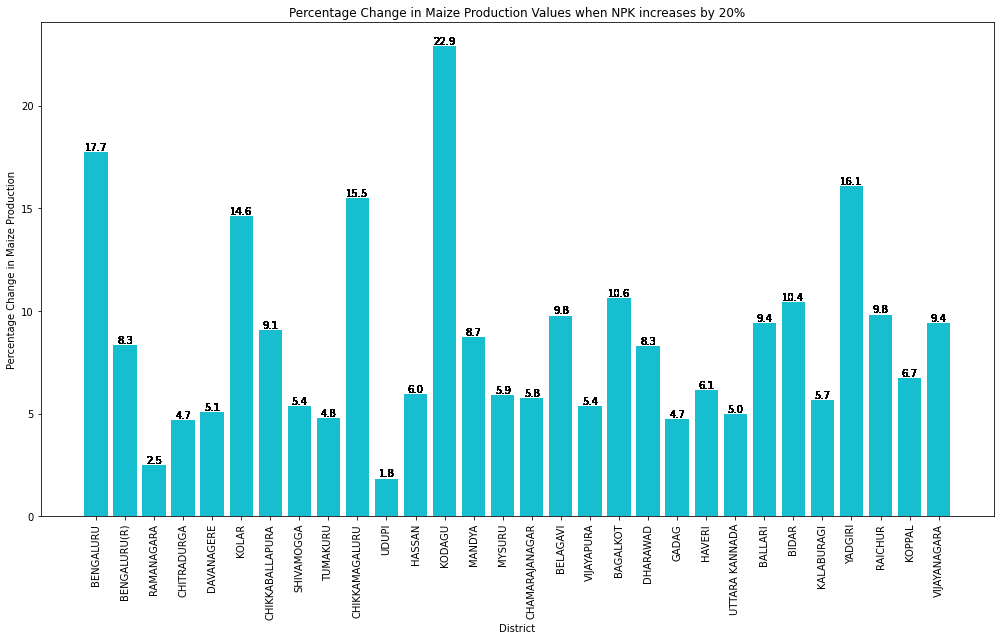

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_visualize(perturbation, crop, Working_Directory, what):
    # Mapping of factor names based on 'what'
    factor_mapping = {
        'NPK': 'TotalNPK',
        'Cattle': 'LivestockCensus_2012_Cattle',
        'MArea': 'AreaUnderCereals_Maize',
    }
    
    # Dynamically select the correct factor and slope column based on 'what'
    factor_name = factor_mapping[what]
    production_col = f'{crop}_Production'
    slope = get_slope(what)

    # Calculate the factor
    factor = Working_Directory[factor_name]
    
    # Initialize an empty list for new values
    New_values = []
    
    # Calculate new values based on the provided formula
    for i in range(len(Working_Directory['District'])):
        y_new = Working_Directory[production_col][i] + slope * (perturbation * factor[i] / 100)
        New_values.append(int(y_new))
    
    # Add the new values to the DataFrame with a specific column name
    Working_Directory[f'{crop[0].upper()} - {what} {perturbation}'] = New_values
    Working_Directory['Change'] =  ((New_values - Working_Directory[production_col])/Working_Directory[production_col])*100
    
    # Ensure all values are finite
    Working_Directory = Working_Directory.replace([np.inf, -np.inf], np.nan).dropna(subset=['Change'])
    
    # Visualization with color-coded zones
    plt.figure(figsize=(14, 9))
    for zone in Working_Directory['District'].unique():
        bars = plt.bar(Working_Directory['District'], 
                       Working_Directory['Change'], 
                       label=zone)
        
        # Add value labels to the bars
        for bar, value in zip(bars, Working_Directory['Change']):
            plt.text(bar.get_x() + bar.get_width() / 2, 
                     bar.get_height(), 
                     f'{value:.1f}', 
                     ha='center', 
                     va='bottom', 
                     fontsize=10)
    
    plt.xlabel('District')
    plt.ylabel(f'Percentage Change in {crop} Production')
    plt.title(f'Percentage Change in {crop} Production Values when {what} increases by {perturbation}%')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage:
perturbation = 20
what = 'NPK'  # Factor to be used
crop = 'Maize'  # Or 'Maize'

# Assuming Working_Directory is a DataFrame that has all necessary columns defined
calculate_and_visualize(perturbation, crop, Working_Directory, what)


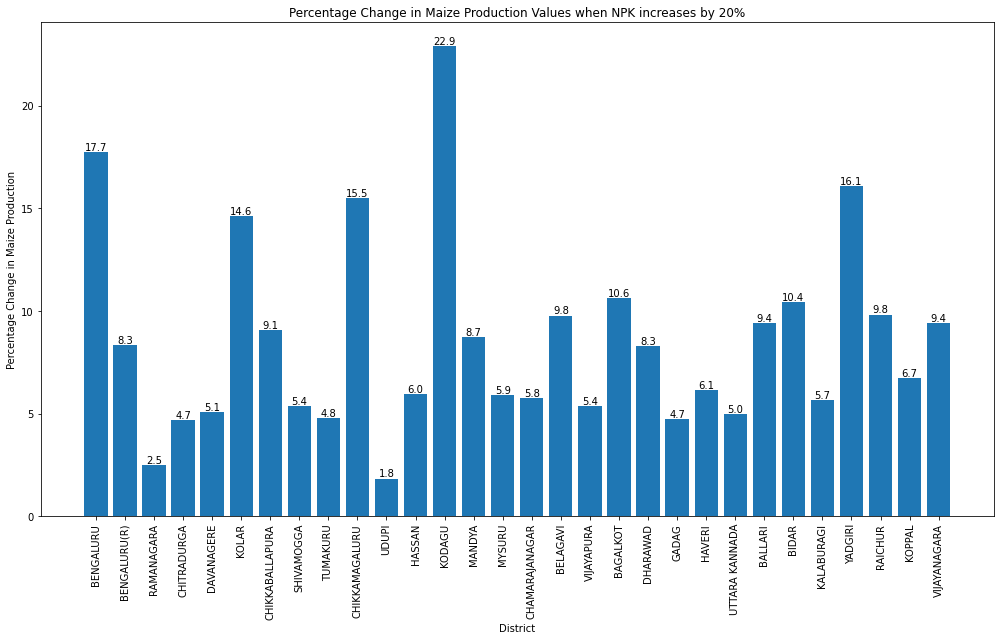

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_visualize(perturbation, crop, Working_Directory, what,plot = True):
    # Mapping of factor names based on 'what'
    factor_mapping = {
        'NPK': 'TotalNPK',
        'Cattle': 'LivestockCensus_2012_Cattle',
        'MArea': 'AreaUnderCereals_Maize',
    }
    
    # Dynamically select the correct factor and slope column based on 'what'
    factor_name = factor_mapping[what]
    production_col = f'{crop}_Production'
    slope = get_slope(what)

    # Calculate the factor
    factor = Working_Directory[factor_name]
    
    # Initialize an empty list for new values
    New_values = []
    
    # Calculate new values based on the provided formula
    for i in range(len(Working_Directory['District'])):
        y_new = Working_Directory[production_col][i] + slope * (perturbation * factor[i] / 100)
        New_values.append(int(y_new))
    
    # Add the new values to the DataFrame with a specific column name
    Working_Directory[f'{crop[0].upper()} - {what} {perturbation}'] = New_values
    Working_Directory['Change'] =  (New_values - Working_Directory[production_col])
    Working_Directory['Percentage Change'] =  ((New_values - Working_Directory[production_col])/Working_Directory[production_col])*100
    Working_Directory = Working_Directory.replace([np.inf, -np.inf], np.nan).dropna(subset=['Percentage Change'])
    
    # Visualization
    if(plot == True):
        plt.figure(figsize=(14, 9))
        bars = plt.bar(Working_Directory['District'], 
                    Working_Directory['Percentage Change'])
        
        # Add value labels to the bars
        for bar, value in zip(bars, Working_Directory['Percentage Change']):
            plt.text(bar.get_x() + bar.get_width() / 2, 
                    bar.get_height(), 
                    f'{value:.1f}', 
                    ha='center', 
                    va='bottom', 
                    fontsize=10)
        
        plt.xlabel('District')
        plt.ylabel(f'Percentage Change in {crop} Production')
        plt.title(f'Percentage Change in {crop} Production Values when {what} increases by {perturbation}%')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# Example usage:
perturbation = 20
what = 'NPK'  # Factor to be used
crop = 'Maize'  # Or 'Maize'

# Assuming Working_Directory is a DataFrame that has all necessary columns defined
calculate_and_visualize(perturbation, crop, Working_Directory, what,plot = True)


In [13]:
import pandas as pd
import numpy as np

adjacency_excel = pd.read_excel('Karnataka_District_Adjacency_File.xlsx')

district_codes = sorted(set(adjacency_excel['District_Code']))

n = len(district_codes)
adj_matrix = np.zeros((n, n), dtype=int)

code_to_index = {code: idx for idx, code in enumerate(district_codes)}

for i in range(len(adjacency_excel)):
    district_code = adjacency_excel['District_Code'][i]
    neighbors = [int(num) for num in str(adjacency_excel['District_Neighbors'][i]).split(',') if num.strip().isdigit()]
    
    for neighbor in neighbors:
        adj_matrix[code_to_index[district_code]][code_to_index[neighbor]] = 1
        adj_matrix[code_to_index[neighbor]][code_to_index[district_code]] = 1  # Assuming adjacency is bidirectional

adj_matrix_df = pd.DataFrame(adj_matrix, index=district_codes, columns=district_codes)

print(adj_matrix_df)

adj_matrix_np = adj_matrix_df.to_numpy()

    1   2   3   4   5   6   7   8   9   10  ...  22  23  24  25  26  27  28  \
1    0   1   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2    1   0   1   0   0   1   1   0   1   0  ...   0   0   0   0   0   0   0   
3    1   1   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   0   0   
4    0   0   0   0   1   0   0   0   1   1  ...   0   0   0   1   0   0   0   
5    0   0   0   1   0   0   0   1   0   1  ...   0   1   0   1   0   0   0   
6    0   1   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
7    0   1   0   0   0   1   0   0   1   0  ...   0   0   0   0   0   0   0   
8    0   0   0   0   1   0   0   0   0   1  ...   0   1   1   0   0   0   0   
9    0   1   1   1   0   0   1   0   0   1  ...   0   0   0   0   0   0   0   
10   0   0   0   1   1   0   0   1   1   0  ...   0   0   0   0   0   0   0   
11   0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   1   0   1  ...   0 

In [14]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    normalized_lst = [(x - min_val) / (max_val - min_val) for x in lst]
    return normalized_lst

Name = 'M - NPK 20'
Capability_list = normalize_list(Working_Directory[f'{Name}'])
# Capability_list

In [15]:
import numpy as np

def calculate_avg_capability(capability, neighbors):
    num_neighbors = len(neighbors)
    if num_neighbors == 0:
        return 0
    sum_capabilities = sum(capability[n] for n in neighbors)
    return sum_capabilities / num_neighbors

def calculate_stress_stability(capability, adjacency_matrix):
    n = len(capability)
    stress = np.zeros(n)
    stability = np.zeros(n)
    
    for i in range(n):
        neighbors = [j for j in range(n) if adjacency_matrix[i][j] == 1 and i != j]
        if len(neighbors) > 0:
            avg_capability = calculate_avg_capability(capability, neighbors)
            stress[i] = np.linalg.norm(avg_capability - capability[i])
            stability[i] = 1 - stress[i]
        else:
            stress[i] = 0  # If no neighbors, stress is zero
            stability[i] = 1
        
    return stress, stability

Name = 'M - NPK 20'

Capability_list = normalize_list(Working_Directory[f'{Name}'])
stress, stability = calculate_stress_stability(Capability_list, adj_matrix_np)

print("Stress values:", stress)
print("Stability values:", stability)

Stress values: [0.03953111 0.00928339 0.07692577 0.13624826 0.6529705  0.12410975
 0.1194918  0.01101074 0.09293209 0.2425317  0.17644276 0.13205151
 0.47217277 0.22797444 0.19929175 0.01094401 0.15380816 0.75189201
 0.0826101  0.05429428 0.33549002 0.19503999 0.38664906 0.40514509
 0.22854291 0.01953376 0.10441804 0.12921419 0.26315374 0.11481688
 0.29639604]
Stability values: [0.96046889 0.99071661 0.92307423 0.86375174 0.3470295  0.87589025
 0.8805082  0.98898926 0.90706791 0.7574683  0.82355724 0.86794849
 0.52782723 0.77202556 0.80070825 0.98905599 0.84619184 0.24810799
 0.9173899  0.94570572 0.66450998 0.80496001 0.61335094 0.59485491
 0.77145709 0.98046624 0.89558196 0.87078581 0.73684626 0.88518312
 0.70360396]


In [16]:
# Combined calculation function
def calculate_metrics(Working_Directory, crop, perturbation, what):
    # Normalize the capability list
    capability_name = f'{crop[0].upper()} - {what} {perturbation}'
    Capability_list = normalize_list(Working_Directory[capability_name])
    
    def calculate_avg_capability(capability, neighbors):
        num_neighbors = len(neighbors)
        if num_neighbors == 0:
            return 0
        return sum(capability[n] for n in neighbors) / num_neighbors

    # Calculate stress and stability
    stress, stability = calculate_stress_stability(Capability_list, adj_matrix_np)
    
    # Calculate the impact as percentage change
    original_production = Working_Directory[f'{crop}_Production']
    new_production = Working_Directory[capability_name]
    impact = ((new_production - original_production) / original_production) * 100

    # Column names
    stability_column_name = f'Stability_{crop[0].upper()}_{what}_{perturbation}'
    stress_column_name = f'Stress_{crop[0].upper()}_{what}_{perturbation}'
    impact_column_name = f'Impact_{crop[0].upper()}_{what}_{perturbation}'

    return stability, stress, impact, stability_column_name, stress_column_name, impact_column_name

In [17]:
# Impact calculation function
def calculate_impact(Working_Directory, crop, perturbation, what):
    # Normalize the capability list
    capability_name = f'{crop[0].upper()} - {what} {perturbation}'

    # Calculate the impact as percentage change
    original_production = Working_Directory[f'{crop}_Production']
    new_production = Working_Directory[capability_name]
    impact = ((new_production - original_production) / original_production) * 100

    # Column names
    impact_column_name = f'Impact_{crop[0].upper()}_{what}_{perturbation}'

    return impact, impact_column_name


In [18]:
# Combined calculation function
def calculate_Change_Impact(Working_Directory, crop, perturbation, what):
    # Normalize the capability list
    calculate_and_visualize(perturbation, crop, Working_Directory, what,False)
    capability_name = f'{crop[0].upper()} - {what} {perturbation}'
    
    # Calculate the impact as percentage change
    original_production = Working_Directory[f'{crop}_Production']
    new_production = Working_Directory[capability_name]
    change = (new_production - original_production) 
    impact = ((new_production - original_production) / original_production) * 100

    return change,impact,new_production


In [19]:
# Perturbations and factor mapping
crop = 'Maize'
perturbations = [10, -10, 20, -20]
factor_mapping = {
    'NPK': 'TotalNPK',
    'Cattle': 'LivestockCensus_2012_Cattle',
    'MArea': 'AreaUnderCereals_Maize',
}

# Initialize an empty DataFrame to store the results
Maize_Diff_Impact = pd.DataFrame()

# Loop over each perturbation and factor
for perturbation in perturbations:
    for factor, mapped_factor in factor_mapping.items():
        # Call the function
        Change, impact, New_Production = calculate_Change_Impact(Working_Directory, crop, perturbation, factor)
        District = Working_Directory['District']
        KDG_District = Working_Directory['KDG_District']
        Orig = Working_Directory[f'{crop}_Production']
        
        # Create a DataFrame with the results
        temp_df = pd.DataFrame({
            'District' : District,
            'KDG_District' : KDG_District,
            'Original Maize Production Value' : Orig,
            'Perturbation': perturbation,
            'Factor': mapped_factor,
            'New Maize Production Values': New_Production,
            'Percentage Change': impact,
            'Change': Change
        })
        
        # Append the results to the final DataFrame
        Maize_Diff_Impact = pd.concat([Maize_Diff_Impact, temp_df], ignore_index=True)

# Display or save the final DataFrame
Maize_Diff_Impact.to_csv('DIA\Maize_Diff_Impact.csv',index=False)
Maize_Diff_Impact

,District,KDG_District,Original Maize Production Value,Perturbation,Factor,New Maize Production Values,Percentage Change,Change
0,BENGALURU,Bengaluru Urban,2879,10,TotalNPK,3134,8.857242,255
1,BENGALURU(R),Bengaluru Rural,42583,10,TotalNPK,44354,4.158937,1771
2,RAMANAGARA,Ramanagara,10450,10,TotalNPK,10579,1.234450,129
3,CHITRADURGA,Chitradurga,271975,10,TotalNPK,278336,2.338818,6361
4,DAVANAGERE,Davanagere,593544,10,TotalNPK,608541,2.526687,14997
...,...,...,...,...,...,...,...,...
367,KALABURAGI,Kalaburagi,14621,-20,AreaUnderCereals_Maize,13684,-6.408590,-937
368,YADGIRI,Yadgir,2673,-20,AreaUnderCereals_Maize,2331,-12.794613,-342
369,RAICHUR,Raichur,723,-20,AreaUnderCereals_Maize,-201,-127.800830,-924
370,KOPPAL,Koppal,190252,-20,AreaUnderCereals_Maize,173103,-9.013834,-17149


In [20]:
# Perturbations and factor mapping
crop = 'Maize'
perturbations = [10, -10, 20, -20]
factor_mapping = {
    'NPK': 'TotalNPK',
    'Cattle': 'LivestockCensus_2012_Cattle',
    'MArea': 'AreaUnderCereals_Maize',
}

# Initialize an empty DataFrame to store the results
Maize_1D_Diff_Impact = pd.DataFrame()

Name = 'Maize_Production'

Capability_list = normalize_list(Working_Directory[f'{Name}'])
init_stress, init_stability = calculate_stress_stability(Capability_list, adj_matrix_np)

# Loop over each perturbation and factor
for perturbation in perturbations:
    for factor, mapped_factor in factor_mapping.items():
        # Call the function
        Change, impact, New_Production = calculate_Change_Impact(Working_Directory, crop, perturbation, factor)
        stability, stress, impact, stability_column_name, stress_column_name, impact_column_name = calculate_metrics(Working_Directory, crop, perturbation, factor)
        
        District = Working_Directory['District']
        KDG_District = Working_Directory['KDG_District']
        Orig = Working_Directory[f'{crop}_Production']
        
        temp_df = pd.DataFrame({
            'District' : District,
            'KDG_District' : KDG_District,
            'Original Maize Production Value' : Orig,
            'Perturbation': perturbation,
            'Factor': mapped_factor,
            'New Maize Production Values': New_Production,
            'Percentage Change': impact,
            'Change': Change,
            'Initial Stress': init_stress,
            'Initial Stability': init_stability,
            'Stress': stress,
            'Stability': stability
        })
        
        # Append the results to the final DataFrame
        Maize_1D_Diff_Impact = pd.concat([Maize_1D_Diff_Impact, temp_df], ignore_index=True)

# Display or save the final DataFrame
Maize_1D_Diff_Impact.to_csv('1D\Maize_1D_Diff_Impact.csv',index=False)
Maize_1D_Diff_Impact

,District,KDG_District,Original Maize Production Value,Perturbation,Factor,New Maize Production Values,Percentage Change,Change,Initial Stress,Initial Stability,Stress,Stability
0,BENGALURU,Bengaluru Urban,2879,10,TotalNPK,3134,8.857242,255,0.039824,0.960176,0.039985,0.960015
1,BENGALURU(R),Bengaluru Rural,42583,10,TotalNPK,44354,4.158937,1771,0.008582,0.991418,0.009014,0.990986
2,RAMANAGARA,Ramanagara,10450,10,TotalNPK,10579,1.234450,129,0.076609,0.923391,0.077377,0.922623
3,CHITRADURGA,Chitradurga,271975,10,TotalNPK,278336,2.338818,6361,0.144899,0.855101,0.141539,0.858461
4,DAVANAGERE,Davanagere,593544,10,TotalNPK,608541,2.526687,14997,0.668253,0.331747,0.665559,0.334441
...,...,...,...,...,...,...,...,...,...,...,...,...
367,KALABURAGI,Kalaburagi,14621,-20,AreaUnderCereals_Maize,13684,-6.408590,-937,0.105540,0.894460,0.110013,0.889987
368,YADGIRI,Yadgir,2673,-20,AreaUnderCereals_Maize,2331,-12.794613,-342,0.131219,0.868781,0.136897,0.863103
369,RAICHUR,Raichur,723,-20,AreaUnderCereals_Maize,-201,-127.800830,-924,0.259924,0.740076,0.267152,0.732848
370,KOPPAL,Koppal,190252,-20,AreaUnderCereals_Maize,173103,-9.013834,-17149,0.118701,0.881299,0.124362,0.875638


In [21]:
import plotly.express as px

# Visualization function
def Calculate_and_visualize_1D(Working_Directory, crop, perturbation, what):
    calculate_and_visualize(perturbation, crop, Working_Directory, what, False)
    stability, stress, impact, stability_column_name, stress_column_name, impact_column_name = calculate_metrics(Working_Directory, crop, perturbation, what)
    
    # Add metrics to Working_Directory DataFrame
    Working_Directory[stability_column_name] = stability
    Working_Directory[stress_column_name] = stress
    Working_Directory[impact_column_name] = impact
    
    # Prepare data for Plotly
    for_plots = Working_Directory[[stability_column_name, impact_column_name, 'Abbreviation']].copy()
    for_plots.rename(columns={stability_column_name: 'stability', impact_column_name: 'Impact'}, inplace=True)

    # Create scatter plot with Plotly
    fig_increase = px.scatter(
        for_plots,
        x='stability',
        y='Impact',
        title=f'Impact vs Stability ({crop} +{perturbation}% {what})',
        labels={'stability': 'Stability', 'Impact': 'Impact'},
        text='Abbreviation',
        size_max=8,
        width=800,
        height=500
    )

    # Update hover labels
    fig_increase.update_traces(
        hoverlabel=dict(bgcolor='grey', font=dict(color='white')),
        textposition='top center'
    )

    # Calculate and add average lines
    avg_x_increase = for_plots['stability'].mean()
    avg_y_increase = for_plots['Impact'].mean()

    fig_increase.add_shape(
        type='line',
        x0=min(for_plots['stability']),
        x1=max(for_plots['stability']),
        y0=avg_y_increase,
        y1=avg_y_increase,
        line=dict(color='blue', width=2, dash='dash')
    )
    fig_increase.add_shape(
        type='line',
        x0=avg_x_increase,
        x1=avg_x_increase,
        y0=min(for_plots['Impact']),
        y1=max(for_plots['Impact']),
        line=dict(color='red', width=2, dash='dash')
    )

    # Add annotations for average lines
    fig_increase.add_annotation(
        x=avg_x_increase,
        y=max(for_plots['Impact']),
        text='Avg Stability',
        showarrow=False,
        font=dict(color='red')
    )
    fig_increase.add_annotation(
        x=max(for_plots['stability']),
        y=avg_y_increase,
        text='Avg Impact',
        showarrow=False,
        font=dict(color='blue')
    )

    # Add tooltips
    fig_increase.update_traces(
        hoverinfo='text+name',
        hovertext=["Impact: " + str(y) +
                   f"<br>Stability: {x}"
                   for x, y in zip(for_plots['stability'], for_plots['Impact'])]
    )

    # Show the plot
    fig_increase.show()

# Example usage
crop = 'Maize'
perturbation = 20
what = 'NPK'
Calculate_and_visualize_1D(Working_Directory, crop, perturbation, what)
